# Investigate Orthologs found exclusivly by assembly based tools

### Steps
1) create dictionary that contains per species all corresponding uniprot IDs
2) create list or set containing all used seed genes
3) read in qfo input files and create df containing per seed gene, number of species orthologs detected and number of species in which it is missing, in how many assembly_based tools it was found
4) filter seed genes in which a pair was exclusivly found by assembly based tools

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
def parse_species_file(file):
    lines = file.readlines()
    species_dict = {}
    for line in lines:
        line = line.rstrip()
        ncbi, name, uniprot_acc, source, refseq_acc = line.split('\t')
        species_dict[ncbi] = {'name': name, 'uniprot': uniprot_acc, 'source': source, 'refseq': refseq_acc}
    return species_dict

In [4]:
species_file = open('../../data/fDOG-assembly/species_set_benchmark.tsv', 'r')
species_dict = parse_species_file(species_file)
species_file.close()

In [5]:
dict_species_vs_id_set = {}
qfo_path = '../../data/qfo_eukaryota_2022/qfo_data_2022/Eukaryota/'
for key in species_dict:
    print(key)
    uniprot_ids_search_species = set()
    file = open(qfo_path + species_dict[key]['uniprot'] + '_' + key + '.fasta', 'r')
    lines = file.readlines()
    for line in lines:
        if line.startswith('>'):
            uniprot_ids_search_species.add(line.split('|')[1])
    dict_species_vs_id_set[key] = uniprot_ids_search_species

45351
10116
9031
8364
7955
7227
7070
6945
6412
6239


In [6]:
def get_seed_genes(path):
    file = open(path, 'r')
    lines = file.readlines()
    seed_genes = set()
    for line in lines:
        line = line.rstrip()
        busco, uniprot = line.split('\t')
        seed_genes.add(uniprot)
        
    return seed_genes

In [7]:
path = '../uniprotid_to_group_assignment/mapping_busco_id_uniport_id.tsv'
seed_genes = get_seed_genes(path)
print(len(seed_genes))
#print(seed_genes)

917


In [8]:
tools_ref = ['bbh', 'domainoid', 'ensamble', 'hieranoid', 'inparanoid', 'metaphors', 'oma_pairs', 'orthoffgc', 'orthofinder', 'orthoinspector', 'panther', 'rsd', 'sonicparanoid']
tools = ['busco_metazoa_augustus', 'busco_metazoa_metaeuk', 'fdog_assembly_metazoa_augustus', 'fdog_assembly_metazoa_augustus_fly', 'fdog_assembly_metazoa_metaeuk', 'fdog_assembly_metazoa_sens_metaeuk']
path = '../../results/qfo_input/'

In [9]:
def create_set_of_sets(path):
    file = open(path, 'r')
    pairs_set = set()
    lines = file.readlines()
    for line in lines:
        line = line.rstrip()
        pairs = frozenset(line.split('\t'))
        pairs_set.add(pairs)
    print(len(lines))
    print(len(pairs_set))
    return pairs_set

In [10]:
list_of_sets_ref = []
dict_of_sets = {}
for i in tools_ref:
    pairs_set = create_set_of_sets(path + i + '.tsv')
    list_of_sets_ref.append(pairs_set)
    dict_of_sets[i] = pairs_set

8738
8738
8945
8945
8168
8168
8422
8422
8487
8487
8979
8979
7973
7973
8616
8616
9372
9372
9006
9006
8906
8906
8606
8606
9126
9126


In [11]:
list_of_sets = []
for t in tools:
    #print(t)
    pairs_set = create_set_of_sets(path + t + '.tsv')
    list_of_sets.append(pairs_set)
    dict_of_sets[t] = pairs_set

8197
8197
8222
8222
7926
7926
7540
7540
7737
7737
7448
7448


In [12]:
def get_frequency_all(list_of_sets_ref, set_dict, tools):
    pair_list = []
    occurence_list = []
    tool_list = []
    for t in tools:
        test_set = set_dict[t]
        for i in test_set:
            occurence = 0
            for set_ref in list_of_sets_ref:
                if i in set_ref:
                    occurence += 1
            pair = list(i)
            pair_list.append('_'.join(pair))
            occurence_list.append(occurence)
            tool_list.append(t)
    data_dict = {'pair': pair_list, 'occurence': occurence_list, 'tool': tool_list}
    df = pd.DataFrame(data_dict)
    return df

In [13]:
print(len(list_of_sets_ref))

13


In [14]:
#get occurrences of all genes in reference tool results and filter for genes that were not found in reference tools
df_occ = get_frequency_all(list_of_sets_ref, dict_of_sets, tools)
df_filtered = df_occ[df_occ['occurence'] < 1].copy()
display(df_filtered)
exclusive_pairs = df_filtered['pair'].copy()

#get seed genes exclusively found once by assembly based tools
display(exclusive_pairs)
exclusive_seeds = set()
for i in exclusive_pairs:
    #print(i)
    #print(type(i))
    try:
        g1, g2 = i.split('_')
        if g1 in seed_genes:
            exclusive_seeds.add(g1)
        elif g2 in seed_genes:
            exclusive_seeds.add(g2)
        else:
            print(f'Error, the gene %s and %s are both no seed genes' %(g1,g2))
    except ValueError:
        if i in seed_genes:
            exclusive_seeds.add(i)
        else:
            print(f'Error, the gene %s no seed genes' %(i))



,pair,occurence,tool
1,Q9N4U1_P51946,0,busco_metazoa_augustus
4,A0A1L1RZ60_Q15005,0,busco_metazoa_augustus
16,Q9IAT6_Q3ZCQ8,0,busco_metazoa_augustus
23,Q7YWU3_Q13888,0,busco_metazoa_augustus
95,A7RL52_O94923,0,busco_metazoa_augustus
...,...,...,...
46948,P90969_Q9NP79,0,fdog_assembly_metazoa_sens_metaeuk
46986,Q13889_Q6DK93,0,fdog_assembly_metazoa_sens_metaeuk
47022,Q9Y2S7_F6RWS7,0,fdog_assembly_metazoa_sens_metaeuk
47048,O43462_P0C6P6,0,fdog_assembly_metazoa_sens_metaeuk


1            Q9N4U1_P51946
4        A0A1L1RZ60_Q15005
16           Q9IAT6_Q3ZCQ8
23           Q7YWU3_Q13888
95           A7RL52_O94923
               ...        
46948        P90969_Q9NP79
46986        Q13889_Q6DK93
47022        Q9Y2S7_F6RWS7
47048        O43462_P0C6P6
47062        F6UTK5_Q9UBP6
Name: pair, Length: 1038, dtype: object

In [15]:
def create_df_seed(tools_ref, tools, dict_of_sets, seed_genes, dict_species_vs_id_set):
    seed_list = []
    species_list = []
    not_found_list = []
    occurence_list = []
    for seed in seed_genes:
        species_set = set()
        occurence = 0
        for tool in tools_ref:
            for pair in dict_of_sets[tool]:
                if seed in pair:
                    for i in pair:
                        if i != seed:
                            ortholog = i
                    for sp in dict_species_vs_id_set:
                        if ortholog in dict_species_vs_id_set[sp]:
                            species_set.add(sp)   
        seed_list.append(seed)
        species_list.append(len(species_set))
        not_found_list.append(10 - len(species_set))
        occurence_list.append(occurence)
        
                            
            
    data_dict = {'seed': seed_list, 'found': species_list, 'not_found': not_found_list}
    df = pd.DataFrame(data_dict)
    return df

In [16]:
print(len(exclusive_seeds))
df = create_df_seed(tools_ref, tools, dict_of_sets, exclusive_seeds, dict_species_vs_id_set)

411


In [17]:
display(df)

,seed,found,not_found
0,Q96DI7,10,0
1,Q9NPF4,10,0
2,Q6P1L8,10,0
3,Q9UQ13,10,0
4,O43395,10,0
...,...,...,...
406,Q1RMZ1,8,2
407,Q7Z3J2,10,0
408,P16930,10,0
409,Q8NBL1,9,1


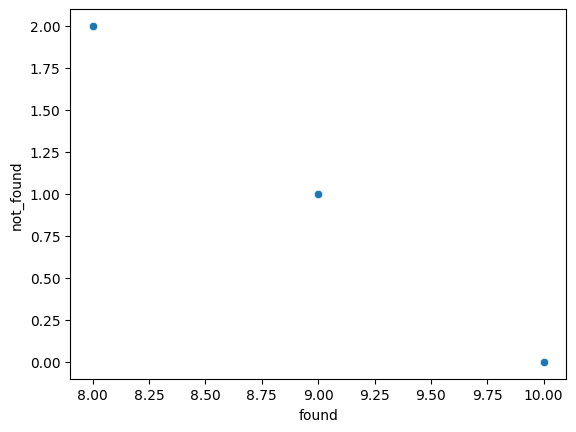

In [21]:
sb.scatterplot(data=df, x="found", y="not_found")
plt.savefig('scatterplot_found_not_found.png')

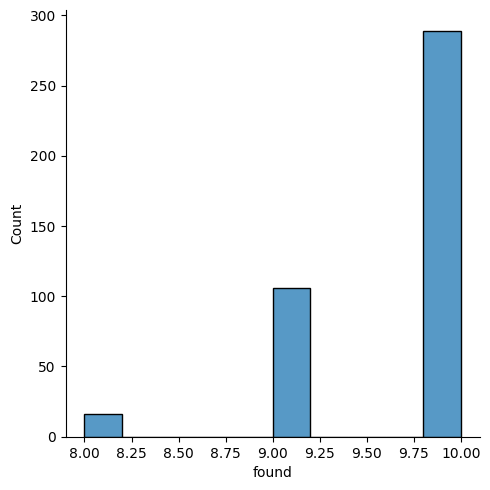

In [22]:
sb.displot(df, x="found")
plt.savefig('displot_found.png')